# Single Species Simulated Read Profiling with Kaiju and CZID

In [1]:
from Bio import Entrez
from Bio import Phylo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from Bio import Entrez
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import matplotlib.cm as cm


In [2]:
wk_dir = '/home/xiangpeng/projects/16S_18S/simulation/kaiju/kaiju_report_simulation/'
out_dir  = '/home/xiangpeng/projects/16S_18S/code_for_github/output/simulation/'

In [3]:
spc_info = pd.read_csv('/home/xiangpeng/projects/16S_18S/simulation/Simulation_species.csv',
                       encoding='ISO-8859-1',
                       sep=',',
                    )
refseq_ls = spc_info['refseq'].tolist()
spc_info = spc_info.drop(columns=['kingdom'])
spc_info = spc_info.set_index('ncbi_id')
spc_info 

,Species,Assembly,refseq,Read_counts
ncbi_id,,,,
36329,Plasmodium falciparum 3D7,GCA_000002765,GCF_000002765.6,1400000
188937,Methanosarcina acetivorans C2A,ASM734v1,GCF_000007345.1,100000
167879,Colwellia psychrerythraea 34H,ASM1232v1,GCF_000012325.1,100000
420247,Methanobrevibacter smithii ATCC 35061,ASM1652v1,GCF_000016525.1,100000
351160,Methanocella arvoryzae MRE50,ASM6344v1,GCF_000063445.1,100000
556484,Phaeodactylum tricornutum CCAP 1055/1,ASM15095v2,GCF_000150955.2,8273014
990316,Methanothrix soehngenii GP6,ASM20441v1,GCF_000204415.1,200000
572307,Neospora caninum Liverpool,ASM20886v2,GCF_000208865.1,1397237
698738,Oleispira antarctica RB-8,ASM96789v1,GCF_000967895.1,100000


In [4]:
# Provide your NCBI API key and email address
Entrez.email = "xiangpenglee@gmail.com"
Entrez.api_key = "95a894e77ba5cd04175ae131ed082859e308"  # Optional but recommended
# Define all taxonomic levels to extract
taxonomic_levels = [
    "superkingdom", "kingdom", "phylum", "class", "order", 
    "family", "genus", "species"
]

# Fetch taxonomy data for each ID
taxids = spc_info.index.tolist()
data = []
for ncbi_id in taxids:
    try:
        handle = Entrez.efetch(db="taxonomy", id=ncbi_id, retmode="xml")
        records = Entrez.read(handle)
        
        # Extract the main record
        record = records[0]
        lineage_ex = record.get("LineageEx", [])  # Get the structured lineage
        
        # Create a dictionary to store the taxonomic levels for this ID
        lineage_dict = {taxon: None for taxon in taxonomic_levels}  # Initialize with None
        lineage_dict["tax_id"] = ncbi_id  # Add the TaxID for reference
        
        # Map the ranks from LineageEx to the defined taxonomic levels
        for entry in lineage_ex:
            rank = entry.get("Rank", "")
            name = entry.get("ScientificName", "")
            if rank in lineage_dict:
                lineage_dict[rank] = name
        
        # Add the species name from the ScientificName field
        lineage_dict["species"] = record.get("ScientificName", None)
        
        data.append(lineage_dict)
    except Exception as e:
        print(f"Error fetching data for ID {ncbi_id}: {e}")

# Convert the data into a pandas DataFrame
df_simulation_id = pd.DataFrame(data)

df_simulation_id = df_simulation_id.set_index('tax_id')

In [5]:

df_simulation_id.shape

(15, 8)

In [6]:

spc_info[taxonomic_levels] = df_simulation_id[taxonomic_levels]


In [7]:
spc_info.to_csv(out_dir +'Simulation_species_with_taxon_labels.csv')
spc_info.head()

,Species,Assembly,refseq,Read_counts,superkingdom,kingdom,phylum,class,order,family,genus,species
ncbi_id,,,,,,,,,,,,
36329,Plasmodium falciparum 3D7,GCA_000002765,GCF_000002765.6,1400000,None,None,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum 3D7
188937,Methanosarcina acetivorans C2A,ASM734v1,GCF_000007345.1,100000,None,Methanobacteriati,Methanobacteriota,Methanomicrobia,Methanosarcinales,Methanosarcinaceae,Methanosarcina,Methanosarcina acetivorans C2A
167879,Colwellia psychrerythraea 34H,ASM1232v1,GCF_000012325.1,100000,None,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Alteromonadales,Colwelliaceae,Colwellia,Colwellia psychrerythraea 34H
420247,Methanobrevibacter smithii ATCC 35061,ASM1652v1,GCF_000016525.1,100000,None,Methanobacteriati,Methanobacteriota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter smithii ATCC 35061
351160,Methanocella arvoryzae MRE50,ASM6344v1,GCF_000063445.1,100000,None,Methanobacteriati,Methanobacteriota,Methanomicrobia,Methanocellales,Methanocellaceae,Methanocella,Methanocella arvoryzae MRE50


### et3 build tree
ete3 ncbiquery --taxdump_file ./taxdump.tar.gz --create
```
Loading node names...
2631852 names loaded.
380905 synonyms loaded.
Loading nodes...
2631852 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /home/xiangpeng/.etetoolkit/taxa.sqlite ...
 2631000 generating entries...
Uploading to /home/xiangpeng/.etetoolkit/taxa.sqlite

Inserting synonyms:      380000
Inserting taxid merges:  85000
Inserting taxids:       2630000
```

In [10]:
from ete3 import NCBITaxa, TreeStyle




# Specify the path to your NCBI taxonomy database (it's typically stored in your home directory)
ncbi = NCBITaxa('/home/xiangpeng/.etetoolkit/taxa.sqlite')

# Example: Querying for a list of taxids (e.g., 9606 for human, 7227 for fruit fly)
taxids = spc_info.index.tolist()

# Generate the tree
tree = ncbi.get_topology(taxids)

# Print the tree in Newick format
print(tree.write(format=0))  # Format 0 prints the tree in Newick format

((((36329:1,572307:1)1:1,556484:1)1:1,29760:1,680683:1)1:1,(((167879:1,1312369:1)1:1,698738:1)1:1,(104268:1,1300343:1)1:1)1:1,((188937:1,990316:1,351160:1)1:1,(1077256:1,420247:1)1:1)1:1);


In [11]:
lineages = ncbi.get_lineage_translator(taxids)
for taxid, lineage in lineages.items():
    names = ncbi.get_taxid_translator(lineage)
    print(f"\nTaxID {taxid} lineage:")
    for tid in lineage:
        print(f"- {names[tid]}")


TaxID 29760 lineage:
- root
- cellular organisms
- Eukaryota
- Viridiplantae
- Streptophyta
- Streptophytina
- Embryophyta
- Tracheophyta
- Euphyllophyta
- Spermatophyta
- Magnoliopsida
- Mesangiospermae
- eudicotyledons
- Gunneridae
- Pentapetalae
- rosids
- rosids incertae sedis
- Vitales
- Vitaceae
- Viteae
- Vitis
- Vitis vinifera

TaxID 36329 lineage:
- root
- cellular organisms
- Eukaryota
- Sar
- Alveolata
- Apicomplexa
- Aconoidasida
- Haemosporida
- Plasmodiidae
- Plasmodium
- Plasmodium (Laverania)
- Plasmodium falciparum
- Plasmodium falciparum 3D7

TaxID 104268 lineage:
- root
- cellular organisms
- Bacteria
- Pseudomonadati
- FCB group
- Bacteroidota/Chlorobiota group
- Bacteroidota
- Flavobacteriia
- Flavobacteriales
- Flavobacteriaceae
- Tenacibaculum
- Tenacibaculum mesophilum

TaxID 167879 lineage:
- root
- cellular organisms
- Bacteria
- Pseudomonadati
- Pseudomonadota
- Gammaproteobacteria
- Alteromonadales
- Colwelliaceae
- Colwellia
- Colwellia psychrerythraea
- C

<Figure size 1000x600 with 0 Axes>

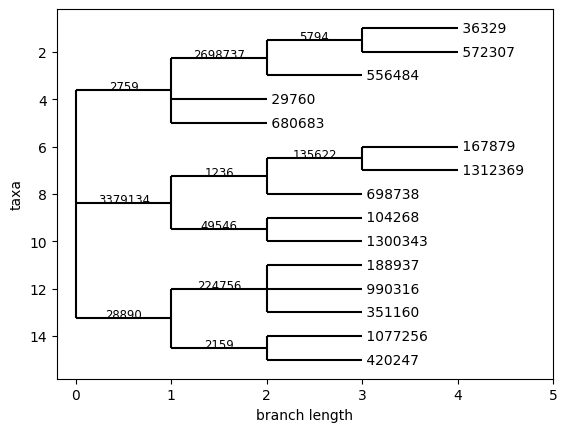

In [12]:
from Bio import Phylo
from io import StringIO
# Convert ETE3 tree to newick format
newick_str = tree.write(format=1)

# Read the newick string with Bio.Phylo
phylo_tree = Phylo.read(StringIO(newick_str), 'newick')

# Plot the tree
plt.figure(figsize=(10, 6))
Phylo.draw(phylo_tree)
plt.show()

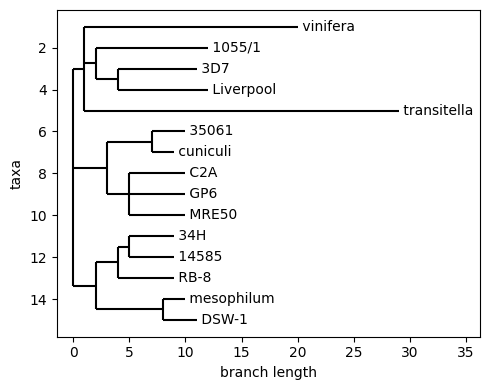

In [14]:
# Create figure with specific size and adjust layout
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)

# Draw tree with custom label function that only labels terminal nodes
Phylo.draw(phylo_tree, 
           axes=ax, 
           do_show=False,
           label_func=lambda x: x.name if x.is_terminal() else '')  # Only label if it's a terminal node

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig(out_dir+ 'simulation_species_tree.pdf')

# Show plot
plt.show()

In [15]:
# Specify the file path where you want to save the tree (e.g., tree.nwk)
output_file_path = out_dir + 'simulation_tree.nwk'  # Update with the desired file path

# Save the tree in Newick format
with open(output_file_path, 'w') as file:
    file.write(tree.write(format=0))

In [17]:
taxa = ['phylum', 'class', 'order', 'family', 'genus', 'species'] 

In [18]:
# combine the 15 kaiju at various taxa level
# kaiju were perfomed in Kbase.  https://narrative.kbase.us/narrative/202362
for t in taxa:
    cmb_df =pd.DataFrame(columns =['taxon_id'])
    column_ls = []
    for refseq in refseq_ls:
        file = '{}{}-{}-longtail.kaijuReport'.format(wk_dir, refseq, t)
        df = pd.read_csv(file, sep = '\t')
        df = df.set_index('taxon_name')
        col = '{}_{}'.format(refseq, t)
        df = df.rename(columns={'reads':col})
        cmb_df = pd.concat([cmb_df,df[[col]]], axis=1)
        cmb_df.loc[df.index, 'taxon_id'] = df['taxon_id'].astype('str')
        column_ls.append(col)
    cmb_df[column_ls]=cmb_df[column_ls]/cmb_df[column_ls].sum()  
    cmb_df.to_csv(out_dir+'kaiju_simulation_combined_{}_level.csv'.format(t))
    print(t)
    print(cmb_df.count())
    

phylum
taxon_id                  120
GCF_000002765.6_phylum     24
GCF_000007345.1_phylum     12
GCF_000012325.1_phylum      9
GCF_000016525.1_phylum      7
GCF_000063445.1_phylum      8
GCF_000150955.2_phylum     41
GCF_000204415.1_phylum     11
GCF_000208865.1_phylum     29
GCF_000967895.1_phylum     12
GCF_001653755.1_phylum      7
GCF_002287195.1_phylum     19
GCF_002310855.1_phylum     11
GCF_009362255.1_phylum      9
GCF_030704535.1_phylum     92
GCF_032362555.1_phylum     89
dtype: int64
class
taxon_id                 174
GCF_000002765.6_class     36
GCF_000007345.1_class     13
GCF_000012325.1_class     10
GCF_000016525.1_class     11
GCF_000063445.1_class      8
GCF_000150955.2_class     82
GCF_000204415.1_class     10
GCF_000208865.1_class     44
GCF_000967895.1_class     14
GCF_001653755.1_class     11
GCF_002287195.1_class     18
GCF_002310855.1_class     14
GCF_009362255.1_class     13
GCF_030704535.1_class    151
GCF_032362555.1_class    132
dtype: int64
order
taxon_id   

In [19]:
czid_dir = '/home/xiangpeng/projects/16S_18S/simulation/czid/single_species_test_17758/'

In [20]:
import os
czid_files = os.listdir(czid_dir)
all_df_nt = pd.DataFrame()
all_df_nr = pd.DataFrame()

for f in czid_files:
    refseq = '_'.join(f.split('_')[:2])
    df =pd.read_csv(czid_dir + f, index_col = 0)
    df = df[df['tax_level']==1]
    df.rename(columns={'nt_rpm': '{}_nt_rpm'.format(refseq), 'nr_rpm': '{}_nr_rpm'.format(refseq)}, inplace=True)
    all_df_nt = pd.concat([all_df_nt, df['{}_nt_rpm'.format(refseq)].div(1000000)], axis =1)
    all_df_nt = all_df_nt.dropna(how='all')
    all_df_nr = pd.concat([all_df_nr, df['{}_nr_rpm'.format(refseq)].div(1000000)], axis =1)
    all_df_nr = all_df_nr.dropna(how='all')

all_df_nr.to_csv(out_dir+ "all_simulation_czid_nr.csv")
all_df_nt.to_csv(out_dir+ "all_simulation_czid_nt.csv")
all_nt_col = all_df_nt.columns.tolist()
all_nr_col = all_df_nr.columns.tolist()

In [21]:
all_tax_id = list((set(all_df_nr.index.tolist())| set(all_df_nt.index.tolist())))

In [22]:
len(all_tax_id)

3221

In [23]:
# Create a list to store the taxonomic information
taxonomic_info = []

# Define the expected ranks in order
rank_order = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']


# Loop through each taxon ID to get detailed taxon information
for taxid in all_tax_id:

    try:
        # Get lineage of the taxon ID
        lineage = ncbi.get_lineage(taxid)
        
        # Get names for each taxon ID in the lineage
        lineage_names = ncbi.get_taxid_translator(lineage)
        
        # Initialize a dictionary to store taxonomic info for this taxid
        taxon_data = {'taxid': taxid}
        
        # Map the lineage ranks to the corresponding taxonomic level
        for i, rank in enumerate(rank_order):
            if i < len(lineage):  # Only assign rank if it exists in the lineage
                taxon_data[rank] = lineage_names.get(lineage[i], '')
            else:
                taxon_data[rank] = ''  # If the rank does not exist, assign an empty string
        
        # Add the taxon data to the list
        taxonomic_info.append(taxon_data)
    
    except ValueError as e:
        # Handle the case where the taxid is not found or merged
        print(f"Error: {e} - Taxid {taxid} not found, skipping.")
        continue

# Convert the list of taxon data into a pandas DataFrame
df_taxonomy = pd.DataFrame(taxonomic_info)

# Display the DataFrame
print(df_taxonomy)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 355208 was translated into 3056719
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2954194 was translated into 345096
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 596624 was translated into 3381338
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 81037 was translated into 77608
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


Error: -100 taxid not found - Taxid -100 not found, skipping.
        taxid kingdom              phylum      class           order  \
0      761859    root  cellular organisms  Eukaryota   Viridiplantae   
1     1425412    root  cellular organisms  Eukaryota    Opisthokonta   
2     1679365    root  cellular organisms  Eukaryota   Viridiplantae   
3           9    root  cellular organisms   Bacteria  Pseudomonadati   
4       49168    root  cellular organisms  Eukaryota   Viridiplantae   
...       ...     ...                 ...        ...             ...   
3215  1581038    root  cellular organisms   Bacteria       Bacillati   
3216  2965489    root  cellular organisms  Eukaryota   Viridiplantae   
3217   286706    root  cellular organisms  Eukaryota    Opisthokonta   
3218  1744888    root  cellular organisms  Eukaryota   Viridiplantae   
3219  1826815    root  cellular organisms  Eukaryota   Viridiplantae   

              family                genus           species  
0       Str

/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 876063 was translated into 3126489
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 245335 was translated into 3238343
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


In [24]:

import pandas as pd
from ete3 import NCBITaxa

# Initialize NCBITaxa with the local taxa.sqlite database
ncbi = NCBITaxa('/home/xiangpeng/.etetoolkit/taxa.sqlite')  # Replace with the correct path

# List of taxon IDs (replace with your own list)
taxids = [9606, 10090, 10116, 9]  # Example taxids

# Create a list to store the taxonomic information
taxonomic_info = []

# Define the rank-to-taxonomic level mapping
rank_to_level = {
    1: 'kingdom',
    2: 'phylum',
    3: 'class',
    4: 'order',
    5: 'family',
    6: 'genus',
    7: 'species'
}

# Loop through each taxon ID to get detailed taxon information
for taxid in taxids:
    try:
        # Get lineage of the taxon ID
        lineage = ncbi.get_lineage(taxid)
        print(f"Lineage for taxid {taxid}: {lineage}")
        
        # Get the ranks for each taxon ID in the lineage
        ranks = ncbi.get_rank(lineage)
        print(f"Ranks for taxid {taxid}: {ranks}")
        
        # Get names for each taxon ID in the lineage
        lineage_names = ncbi.get_taxid_translator(lineage)
        print(f"Names for taxid {taxid}: {lineage_names}")
        
        # Initialize a dictionary to store taxonomic info for this taxid
        taxon_data = {'taxid': taxid}
        
        # Loop through each taxon ID in the lineage to map it to the correct rank
        for taxid_in_lineage in lineage:
            rank = ranks[taxid_in_lineage]  # Get the rank for this taxon ID
            name = lineage_names.get(taxid_in_lineage, '')
            print(f"Taxid: {taxid_in_lineage}, Rank: {rank}, Name: {name}")
            
            # Assign the taxon name to the correct taxonomic level based on the rank
            if rank in rank_to_level:
                level = rank_to_level[rank]
                taxon_data[level] = name  # Assign the name to the taxonomic level
        
        # Ensure missing ranks are handled (e.g., species not always available)
        for level in ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']:
            if level not in taxon_data:
                taxon_data[level] = ''
        
        # Add the taxon data to the list
        taxonomic_info.append(taxon_data)
    
    except ValueError as e:
        # Handle the case where the taxid is not found or merged
        print(f"Error: {e} - Taxid {taxid} not found, skipping.")
        continue

# Convert the list of taxon data into a pandas DataFrame
df_taxonomy = pd.DataFrame(taxonomic_info)

# Display the DataFrame
df_taxonomy.head()



Lineage for taxid 9606: [1, 131567, 2759, 33154, 33208, 6072, 33213, 33511, 7711, 89593, 7742, 7776, 117570, 117571, 8287, 1338369, 32523, 32524, 40674, 32525, 9347, 1437010, 314146, 9443, 376913, 314293, 9526, 314295, 9604, 207598, 9605, 9606]
Ranks for taxid 9606: {1: 'no rank', 2759: 'superkingdom', 6072: 'clade', 7711: 'phylum', 7742: 'clade', 7776: 'clade', 8287: 'superclass', 9347: 'clade', 9443: 'order', 9526: 'parvorder', 9604: 'family', 9605: 'genus', 9606: 'species', 32523: 'clade', 32524: 'clade', 32525: 'clade', 33154: 'clade', 33208: 'kingdom', 33213: 'clade', 33511: 'clade', 40674: 'class', 89593: 'subphylum', 117570: 'clade', 117571: 'clade', 131567: 'no rank', 207598: 'subfamily', 314146: 'superorder', 314293: 'infraorder', 314295: 'superfamily', 376913: 'suborder', 1338369: 'clade', 1437010: 'clade'}
Names for taxid 9606: {1: 'root', 2759: 'Eukaryota', 6072: 'Eumetazoa', 7711: 'Chordata', 7742: 'Vertebrata', 7776: 'Gnathostomata', 8287: 'Sarcopterygii', 9347: 'Eutheria

,taxid,kingdom,phylum,class,order,family,genus,species
0,9606,,,,,,,
1,10090,,,,,,,
2,10116,,,,,,,
3,9,,,,,,,


In [25]:
# Provide your NCBI API key and email address
Entrez.email = "xiangpenglee@gmail.com"
Entrez.api_key = "95a894e77ba5cd04175ae131ed082859e308"  # Optional but recommended

In [26]:
# Define all taxonomic levels to extract
taxonomic_levels = [
    "superkingdom", "kingdom", "phylum", "class", "order", 
    "family", "genus", "species"
]

# Initialize a list to store the results
data = []


# Start the overall timer
start_time = time.time()


# Fetch taxonomy data for each ID
for ncbi_id in all_tax_id:
    try:
        handle = Entrez.efetch(db="taxonomy", id=ncbi_id, retmode="xml")
        records = Entrez.read(handle)
        
        # Extract the main record
        record = records[0]
        lineage_ex = record.get("LineageEx", [])  # Get the structured lineage
        
        # Create a dictionary to store the taxonomic levels for this ID
        lineage_dict = {taxon: None for taxon in taxonomic_levels}  # Initialize with None
        lineage_dict["tax_id"] = ncbi_id  # Add the TaxID for reference
        
        # Map the ranks from LineageEx to the defined taxonomic levels
        for entry in lineage_ex:
            rank = entry.get("Rank", "")
            name = entry.get("ScientificName", "")
            if rank in lineage_dict:
                lineage_dict[rank] = name
        
        # Add the species name from the ScientificName field
        lineage_dict["species"] = record.get("ScientificName", None)
        
        data.append(lineage_dict)
    except Exception as e:
        print(f"Error fetching data for ID {ncbi_id}: {e}")

# Convert the data into a pandas DataFrame
df = pd.DataFrame(data)

# End the overall timer
end_time = time.time()
print(f"Total time taken to fetch and process all data: {end_time - start_time:.2f} seconds")


# Save to a CSV file
df.to_csv(out_dir + "simulation_czi_ncbi_id_to_taxon.csv", index=False)

df.head()

KeyboardInterrupt: 

In [ ]:
import re
error_messages = [
'Error fetching data for ID 59277: HTTP Error 400: Bad Request',
'Error fetching data for ID 323211: HTTP Error 400: Bad Request',
'Total time taken to fetch and process all data: 948.84 seconds',]
# Regular expression to match IDs in the error messages
id_pattern = r"ID (\d+)"

# Extract IDs using the regular expression
failed_ids = [re.search(id_pattern, msg).group(1) for msg in error_messages if re.search(id_pattern, msg)]

# Print the extracted IDs
print(f"Extracted IDs: {failed_ids}")
# then redo the taxonomic annotation for all the failed ids


In [ ]:
# Fetch taxonomy data for each ID
for ncbi_id in failed_ids:
    try:
        handle = Entrez.efetch(db="taxonomy", id=ncbi_id, retmode="xml")
        records = Entrez.read(handle)
        
        # Extract the main record
        record = records[0]
        lineage_ex = record.get("LineageEx", [])  # Get the structured lineage
        
        # Create a dictionary to store the taxonomic levels for this ID
        lineage_dict = {taxon: None for taxon in taxonomic_levels}  # Initialize with None
        lineage_dict["tax_id"] = ncbi_id  # Add the TaxID for reference
        
        # Map the ranks from LineageEx to the defined taxonomic levels
        for entry in lineage_ex:
            rank = entry.get("Rank", "")
            name = entry.get("ScientificName", "")
            if rank in lineage_dict:
                lineage_dict[rank] = name
        
        # Add the species name from the ScientificName field
        lineage_dict["species"] = record.get("ScientificName", None)
        
        data.append(lineage_dict)
    except Exception as e:
        print(f"Error fetching data for ID {ncbi_id}: {e}")

# Convert the data into a pandas DataFrame
df_new = pd.DataFrame(data)



In [33]:
ref_order = ['GCF_030704535.1',
'GCF_000150955.2',
'GCF_000002765.6',
'GCF_000208865.1',
'GCF_032362555.1',
'GCF_000016525.1',
'GCF_002287195.1',
'GCF_000007345.1',
'GCF_000204415.1',
'GCF_000063445.1',
'GCF_000012325.1',
'GCF_002310855.1',
'GCF_000967895.1',
'GCF_009362255.1',
'GCF_001653755.1',]



In [ ]:
df_new = df_new.drop_duplicates(subset="tax_id", keep="first")
# Save to a CSV file
df_new.to_csv(out_dir + "simulation_czi_ncbi_id_to_taxon_all.csv", index=False)

#cp  simulation_czi_ncbi_id_to_taxon.csv /home/xiangpeng/projects/16S_18S/code_for_github/data/simulation/czid/

In [29]:
df_new = pd.read_csv(wk_dir + "simulation_czi_ncbi_id_to_taxon_all.csv", )
df_new

,superkingdom,kingdom,phylum,class,order,family,genus,species,tax_id
0,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Dipsacales,Caprifoliaceae,Diabelia,Diabelia spathulata,761859
1,Eukaryota,Metazoa,Arthropoda,Insecta,Hemiptera,Aphididae,Periphyllus,Periphyllus acericola,1425412
2,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Malpighiales,Salicaceae,Homalium,Homalium ceylanicum,1679365
3,Bacteria,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Enterobacterales,Erwiniaceae,Buchnera,Buchnera aphidicola,9
4,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Ericales,Ericaceae,Rhododendron,Rhododendron molle,49168
...,...,...,...,...,...,...,...,...,...
3216,Eukaryota,Metazoa,Arthropoda,Insecta,Hemiptera,Pentatomidae,Halyomorpha,Halyomorpha halys,286706
3217,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Caryophyllales,Nepenthaceae,Nepenthes,Nepenthes ventricosa x Nepenthes alata,1744888
3218,Eukaryota,Viridiplantae,Streptophyta,Magnoliopsida,Rosales,Rosaceae,Pourthiaea,Pourthiaea amphidoxa,1826815
3219,Archaea,Methanobacteriati,Methanobacteriota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobacterium,Methanobacterium subterraneum,59277


In [30]:
df_new= pd.read_csv(wk_dir + "simulation_czi_ncbi_id_to_taxon_all.csv",)
rank_order = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
df_new = df_new.set_index('tax_id')
all_df_nr[rank_order] = df_new[rank_order]
all_df_nt[rank_order] = df_new[rank_order]
all_df_nr.to_csv(out_dir+ "all_simulation_czid_nr.csv")
all_df_nt.to_csv(out_dir+ "all_simulation_czid_nt.csv")

In [31]:
all_shannon = pd.DataFrame()


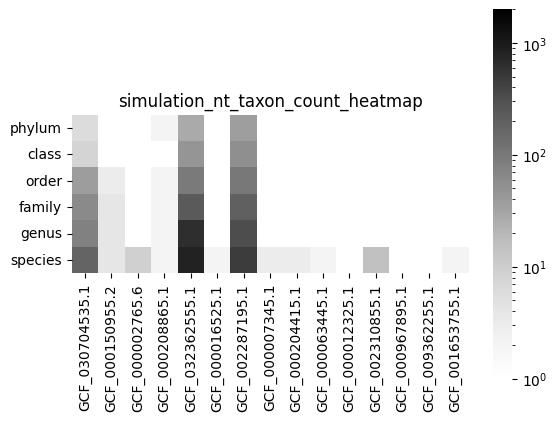

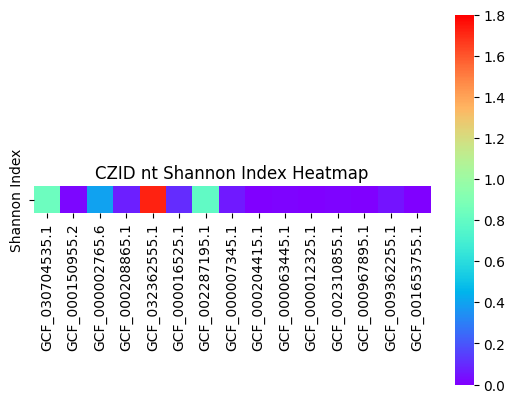

,GCF_030704535.1,GCF_000150955.2,GCF_000002765.6,GCF_000208865.1,GCF_032362555.1,GCF_000016525.1,GCF_002287195.1,GCF_000007345.1,GCF_000204415.1,GCF_000063445.1,GCF_000012325.1,GCF_002310855.1,GCF_000967895.1,GCF_009362255.1,GCF_001653755.1
Shannon Index,0.836119,0.016058,0.399345,0.072483,1.716516,0.101977,0.791472,0.060332,0.002875,0.010522,0.00624,0.009222,0.004888,0.045125,0.007023


In [34]:
czid_nt_taxon_count = pd.DataFrame()
for t in rank_order[1:]:
    df = all_df_nt.groupby(t)[all_nt_col].sum()
    df = df.replace(0,np.nan)
    czid_nt_taxon_count[t] = df.count()

czid_nt_taxon_count.index = czid_nt_taxon_count.index.str.replace('_nt_rpm', '', regex=True)   
czid_nt_taxon_count = czid_nt_taxon_count.loc[ref_order]
sns.heatmap(czid_nt_taxon_count.T,
            norm=LogNorm(vmax = 2000,vmin =1,),
            cmap='Greys',
            square= True,
           
           )
plt.title("simulation_nt_taxon_count_heatmap")
plt.savefig(out_dir+'simulation_nt_taxon_count_heatmap.pdf')
czid_nt_taxon_count.to_csv(out_dir+'simulation_nt_taxon_count_heatmap.csv')
plt.show()

def shannon_index(column):
    """
    Calculate the Shannon index for a column of relative abundances.
    NaN values are ignored.
    """
    column = column.dropna()  # Remove NaN values
    column = column[column > 0]  # Remove zero values to avoid log(0)
    return -np.sum(column * np.log(column))



# Calculate Shannon index for each column
df.columns=df.columns.str.replace('_nt_rpm', '', regex=True)   
df=df.loc[:, ref_order]

# Calculate Shannon index for each column
shannon_indices = df.apply(shannon_index, axis=0)


# Convert to DataFrame for heatmap
shannon_df = pd.DataFrame(shannon_indices, columns=["Shannon Index"]).T

# Plot heatmap
sns.heatmap(shannon_df,
            #annot=True,
            square = True,            
            cmap="rainbow",
            vmin=0,
            vmax = 1.8
           )
plt.title("CZID nt Shannon Index Heatmap")
plt.savefig(out_dir+'simulation_czid_nt_shannon_heatmap.pdf')
plt.show()
all_shannon['czid_nt'] = shannon_df.T
shannon_df.head()


In [35]:
all_df_nt

,GCF_000967895.1_nt_rpm,GCF_001653755.1_nt_rpm,GCF_030704535.1_nt_rpm,GCF_000208865.1_nt_rpm,GCF_032362555.1_nt_rpm,GCF_000204415.1_nt_rpm,GCF_002310855.1_nt_rpm,GCF_000150955.2_nt_rpm,GCF_000007345.1_nt_rpm,GCF_009362255.1_nt_rpm,...,GCF_000016525.1_nt_rpm,GCF_000063445.1_nt_rpm,GCF_000012325.1_nt_rpm,kingdom,phylum,class,order,family,genus,species
188908,0.9951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Oceanospirillales,Oceanospirillaceae,Oleispira,Oleispira antarctica
326320,NaN,0.99317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Pseudomonadati,Bacteroidota,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Dokdonia,Dokdonia donghaensis
313590,NaN,0.00002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Pseudomonadati,Bacteroidota,Flavobacteriia,Flavobacteriales,Flavobacteriaceae,Dokdonia,Dokdonia sp. MED134
149353,NaN,NaN,4.257935e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Viridiplantae,Streptophyta,Magnoliopsida,Vitales,Vitaceae,Causonis,Causonis japonica
2136672,NaN,NaN,4.257935e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,Viridiplantae,Streptophyta,Magnoliopsida,Myrtales,Melastomataceae,Sarcopyramis,Sarcopyramis napalensis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5850,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium knowlesi
5833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum
1175445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.989785,NaN,Methanobacteriati,Methanobacteriota,Methanomicrobia,Methanocellales,Methanocellaceae,Methanocella,Methanocella arvoryzae
115547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,uncultured archaeon


In [36]:
all_shannon

,czid_nt
GCF_030704535.1,0.836119
GCF_000150955.2,0.016058
GCF_000002765.6,0.399345
GCF_000208865.1,0.072483
GCF_032362555.1,1.716516
GCF_000016525.1,0.101977
GCF_002287195.1,0.791472
GCF_000007345.1,0.060332
GCF_000204415.1,0.002875
GCF_000063445.1,0.010522


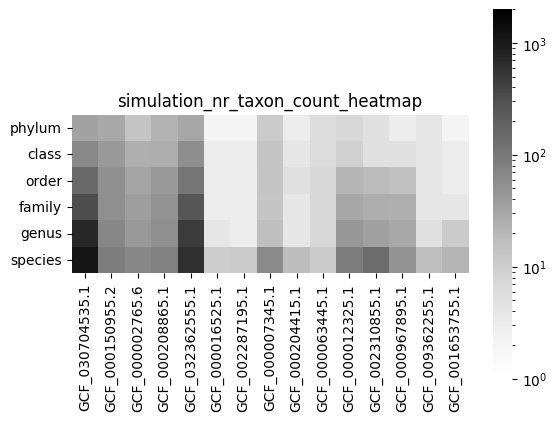

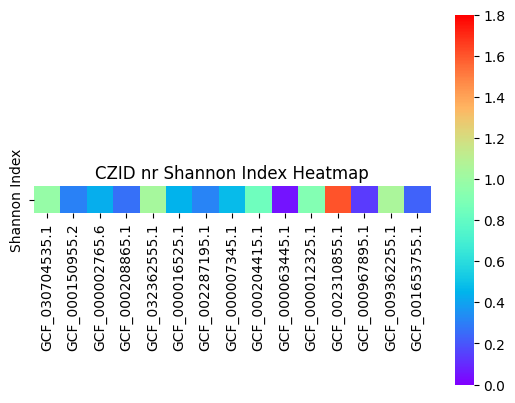

,GCF_030704535.1,GCF_000150955.2,GCF_000002765.6,GCF_000208865.1,GCF_032362555.1,GCF_000016525.1,GCF_002287195.1,GCF_000007345.1,GCF_000204415.1,GCF_000063445.1,GCF_000012325.1,GCF_002310855.1,GCF_000967895.1,GCF_009362255.1,GCF_001653755.1
Shannon Index,0.978403,0.304547,0.43327,0.262981,1.03641,0.449211,0.309834,0.477192,0.84178,0.043016,0.908343,1.608742,0.135793,1.050453,0.226608


In [37]:
czid_nr_taxon_count = pd.DataFrame()
for t in rank_order[1:]:
    df = all_df_nr.groupby(t)[all_nr_col].sum()
    df = df.replace(0,np.nan)
    czid_nr_taxon_count[t] = df.count()
    
czid_nr_taxon_count.index = czid_nr_taxon_count.index.str.replace('_nr_rpm', '', regex=True)   
czid_nr_taxon_count = czid_nr_taxon_count.loc[ref_order]

sns.heatmap(czid_nr_taxon_count.T,
            norm=LogNorm(vmax = 2000,vmin =1,),
            cmap='Greys',
            square= True,
              
           )
plt.title("simulation_nr_taxon_count_heatmap")
plt.savefig(out_dir+'simulation_nr_taxon_count_heatmap.pdf')
plt.show()

czid_nr_taxon_count.to_csv(out_dir+'simulation_nr_taxon_count_heatmap.csv')


# Calculate Shannon index for each column
df.columns=df.columns.str.replace('_nr_rpm', '', regex=True)   
df=df.loc[:, ref_order]

# Calculate Shannon index for each column
shannon_indices = df.apply(shannon_index, axis=0)


# Convert to DataFrame for heatmap
shannon_df = pd.DataFrame(shannon_indices, columns=["Shannon Index"]).T

# Plot heatmap
sns.heatmap(shannon_df,
            #annot=True,
            square = True,            
            cmap="rainbow",
            vmin=0,
            vmax = 1.8
           )
plt.title("CZID nr Shannon Index Heatmap")
plt.savefig(out_dir+'simulation_czid_nr_shannon_heatmap.pdf')
plt.show()
all_shannon['czid_nr'] = shannon_df.T
shannon_df.head()


In [ ]:
shannon_df

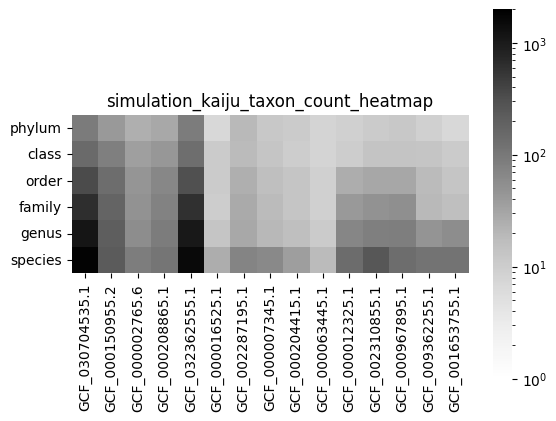

In [38]:
kaiju_taxon_count = pd.DataFrame()
for t in rank_order[1:]:
    cmb_df=pd.read_csv(out_dir+'kaiju_simulation_combined_{}_level.csv'.format(t), index_col=0)
    cmb_df = cmb_df.drop(columns=['taxon_id'])
    cmb_df.columns = cmb_df.columns.str.replace('_'+t, '', regex=True)
    kaiju_taxon_count[t] = cmb_df.count()

kaiju_taxon_count = kaiju_taxon_count.loc[ref_order]

sns.heatmap( kaiju_taxon_count.T,
            norm=LogNorm(vmax = 2000,vmin =1,),
            cmap='Greys',
            square= True,
              
           )
plt.title("simulation_kaiju_taxon_count_heatmap")
plt.savefig(out_dir+'simulation_kaiju_taxon_count_heatmap.pdf')
czid_nr_taxon_count.to_csv(out_dir+'simulation_kaiju_taxon_count_heatmap.csv')
    

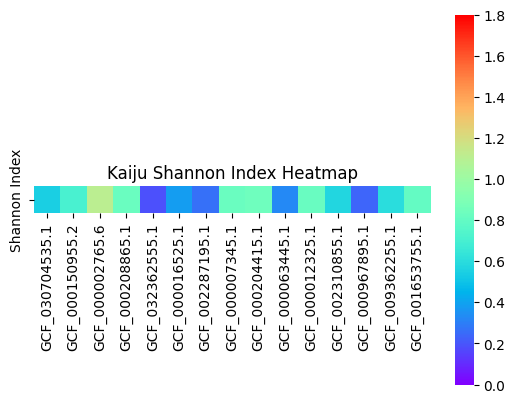

,GCF_030704535.1,GCF_000150955.2,GCF_000002765.6,GCF_000208865.1,GCF_032362555.1,GCF_000016525.1,GCF_002287195.1,GCF_000007345.1,GCF_000204415.1,GCF_000063445.1,GCF_000012325.1,GCF_002310855.1,GCF_000967895.1,GCF_009362255.1,GCF_001653755.1
Shannon Index,0.541478,0.705999,1.107688,0.829159,0.18854,0.381178,0.265163,0.82752,0.842869,0.328513,0.821045,0.56978,0.2379,0.599515,0.805807


In [39]:

def shannon_index(column):
    """
    Calculate the Shannon index for a column of relative abundances.
    NaN values are ignored.
    """
    column = column.dropna()  # Remove NaN values
    column = column[column > 0]  # Remove zero values to avoid log(0)
    return -np.sum(column * np.log(column))


# Calculate Shannon index for each column
cmb_df=cmb_df.loc[:, ref_order]

# Calculate Shannon index for each column
shannon_indices = cmb_df.apply(shannon_index, axis=0)


# Convert to DataFrame for heatmap
shannon_df = pd.DataFrame(shannon_indices, columns=["Shannon Index"]).T

# Plot heatmap
sns.heatmap(shannon_df,
            #annot=True,
            square = True,            
            cmap="rainbow",
            vmin=0,
            vmax = 1.8
           )
plt.title("Kaiju Shannon Index Heatmap")
plt.savefig(out_dir+'simulation_kaiju_shannon_heatmap.pdf')
plt.show()
all_shannon['kaiju'] = shannon_df.T
shannon_df.head()

In [40]:
all_shannon.to_csv(out_dir+'simulation_all_method_shannon_index.csv')

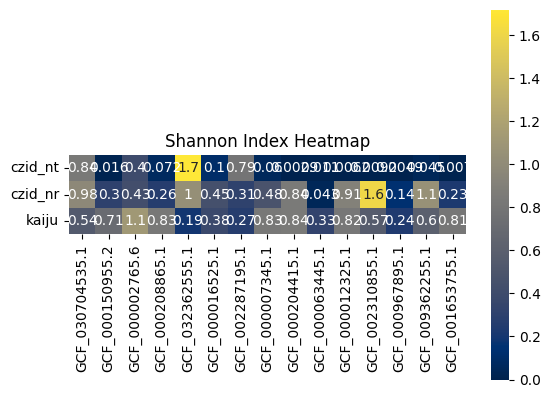

In [41]:

# Plot heatmap
sns.heatmap(all_shannon.T,
            #annot=True,
            square = True,            
            cmap="cividis",
            vmin=0,
            annot= True
           )
plt.title("Shannon Index Heatmap")
plt.savefig(out_dir+'simulation_all_shannon_heatmap.pdf')
plt.show()


In [42]:
spc_info.set_index('refseq')

,Species,Assembly,Read_counts,superkingdom,kingdom,phylum,class,order,family,genus,species
refseq,,,,,,,,,,,
GCF_000002765.6,Plasmodium falciparum 3D7,GCA_000002765,1400000,None,None,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum 3D7
GCF_000007345.1,Methanosarcina acetivorans C2A,ASM734v1,100000,None,Methanobacteriati,Methanobacteriota,Methanomicrobia,Methanosarcinales,Methanosarcinaceae,Methanosarcina,Methanosarcina acetivorans C2A
GCF_000012325.1,Colwellia psychrerythraea 34H,ASM1232v1,100000,None,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Alteromonadales,Colwelliaceae,Colwellia,Colwellia psychrerythraea 34H
GCF_000016525.1,Methanobrevibacter smithii ATCC 35061,ASM1652v1,100000,None,Methanobacteriati,Methanobacteriota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter smithii ATCC 35061
GCF_000063445.1,Methanocella arvoryzae MRE50,ASM6344v1,100000,None,Methanobacteriati,Methanobacteriota,Methanomicrobia,Methanocellales,Methanocellaceae,Methanocella,Methanocella arvoryzae MRE50
GCF_000150955.2,Phaeodactylum tricornutum CCAP 1055/1,ASM15095v2,8273014,None,None,Bacillariophyta,Bacillariophyceae,Naviculales,Phaeodactylaceae,Phaeodactylum,Phaeodactylum tricornutum CCAP 1055/1
GCF_000204415.1,Methanothrix soehngenii GP6,ASM20441v1,200000,None,Methanobacteriati,Methanobacteriota,Methanomicrobia,Methanotrichales,Methanotrichaceae,Methanothrix,Methanothrix soehngenii GP6
GCF_000208865.1,Neospora caninum Liverpool,ASM20886v2,1397237,None,None,Apicomplexa,Conoidasida,Eucoccidiorida,Sarcocystidae,Neospora,Neospora caninum Liverpool
GCF_000967895.1,Oleispira antarctica RB-8,ASM96789v1,100000,None,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Oceanospirillales,Oceanospirillaceae,Oleispira,Oleispira antarctica RB-8


In [43]:
cmb_df=pd.read_csv(out_dir+'kaiju_simulation_combined_{}_level.csv'.format(rank_order[-2]), index_col=0)
cmb_df.loc['Methanothrix']

taxon_id                 2.222000e+03
GCF_000002765.6_genus             NaN
GCF_000007345.1_genus    1.500000e-04
GCF_000012325.1_genus             NaN
GCF_000016525.1_genus             NaN
GCF_000063445.1_genus             NaN
GCF_000150955.2_genus             NaN
GCF_000204415.1_genus    9.579950e-01
GCF_000208865.1_genus             NaN
GCF_000967895.1_genus             NaN
GCF_001653755.1_genus             NaN
GCF_002287195.1_genus             NaN
GCF_002310855.1_genus             NaN
GCF_009362255.1_genus             NaN
GCF_030704535.1_genus             NaN
GCF_032362555.1_genus    3.030303e-07
Name: Methanothrix, dtype: float64

In [44]:
spc_info

,Species,Assembly,refseq,Read_counts,superkingdom,kingdom,phylum,class,order,family,genus,species
ncbi_id,,,,,,,,,,,,
36329,Plasmodium falciparum 3D7,GCA_000002765,GCF_000002765.6,1400000,None,None,Apicomplexa,Aconoidasida,Haemosporida,Plasmodiidae,Plasmodium,Plasmodium falciparum 3D7
188937,Methanosarcina acetivorans C2A,ASM734v1,GCF_000007345.1,100000,None,Methanobacteriati,Methanobacteriota,Methanomicrobia,Methanosarcinales,Methanosarcinaceae,Methanosarcina,Methanosarcina acetivorans C2A
167879,Colwellia psychrerythraea 34H,ASM1232v1,GCF_000012325.1,100000,None,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Alteromonadales,Colwelliaceae,Colwellia,Colwellia psychrerythraea 34H
420247,Methanobrevibacter smithii ATCC 35061,ASM1652v1,GCF_000016525.1,100000,None,Methanobacteriati,Methanobacteriota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,Methanobrevibacter smithii ATCC 35061
351160,Methanocella arvoryzae MRE50,ASM6344v1,GCF_000063445.1,100000,None,Methanobacteriati,Methanobacteriota,Methanomicrobia,Methanocellales,Methanocellaceae,Methanocella,Methanocella arvoryzae MRE50
556484,Phaeodactylum tricornutum CCAP 1055/1,ASM15095v2,GCF_000150955.2,8273014,None,None,Bacillariophyta,Bacillariophyceae,Naviculales,Phaeodactylaceae,Phaeodactylum,Phaeodactylum tricornutum CCAP 1055/1
990316,Methanothrix soehngenii GP6,ASM20441v1,GCF_000204415.1,200000,None,Methanobacteriati,Methanobacteriota,Methanomicrobia,Methanotrichales,Methanotrichaceae,Methanothrix,Methanothrix soehngenii GP6
572307,Neospora caninum Liverpool,ASM20886v2,GCF_000208865.1,1397237,None,None,Apicomplexa,Conoidasida,Eucoccidiorida,Sarcocystidae,Neospora,Neospora caninum Liverpool
698738,Oleispira antarctica RB-8,ASM96789v1,GCF_000967895.1,100000,None,Pseudomonadati,Pseudomonadota,Gammaproteobacteria,Oceanospirillales,Oceanospirillaceae,Oleispira,Oleispira antarctica RB-8


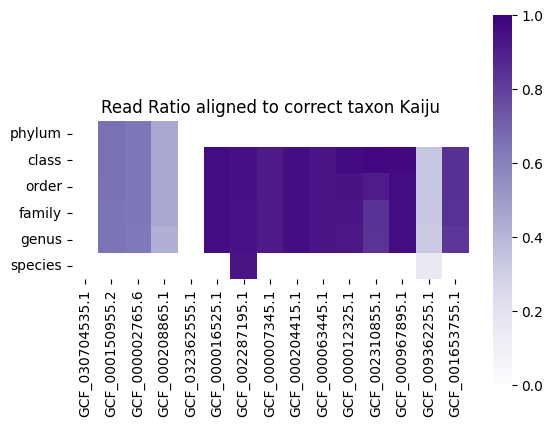

In [45]:
Kaiju_aligned_percentage = pd.DataFrame()

for t in rank_order[1:]:
    
    cmb_df=pd.read_csv(out_dir+'kaiju_simulation_combined_{}_level.csv'.format(t), index_col=0)
    cmb_df = cmb_df.drop(columns=['taxon_id'])
    cmb_df.columns = cmb_df.columns.str.replace('_' + t, '', regex=True)
    ref_t_dict = spc_info.set_index('refseq')[t].to_dict()
    for r in ref_order:
        ref = ref_t_dict[r]
        try:
            a = cmb_df.loc[ref,r]
        except KeyError:
            a = 0
        #print(a)
        Kaiju_aligned_percentage.loc[t,r]=a
sns.heatmap(Kaiju_aligned_percentage.replace(0, np.nan), square=True,cmap='Purples',vmin=0, vmax=1,)
plt.title("Read Ratio aligned to correct taxon Kaiju")
plt.savefig(out_dir+'Read_Ratio_aligned_to_correct_taxon_kaiju.pdf')

plt.show()
        
Kaiju_aligned_percentage.to_csv(out_dir+'Read_Ratio_aligned_to_correct_taxon_kaiju.csv')        

In [46]:
Kaiju_aligned_percentage

,GCF_030704535.1,GCF_000150955.2,GCF_000002765.6,GCF_000208865.1,GCF_032362555.1,GCF_000016525.1,GCF_002287195.1,GCF_000007345.1,GCF_000204415.1,GCF_000063445.1,GCF_000012325.1,GCF_002310855.1,GCF_000967895.1,GCF_009362255.1,GCF_001653755.1
phylum,0.0,0.659949,0.638249,0.455854,0.0,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.00000,0.00000
class,0.0,0.658275,0.638140,0.455640,0.0,0.96103,0.945392,0.91710,0.958160,0.93118,0.96569,0.978670,0.97572,0.32951,0.85102
order,0.0,0.655083,0.638092,0.455621,0.0,0.96103,0.945392,0.91677,0.957995,0.93067,0.93917,0.908340,0.96420,0.32896,0.84993
family,0.0,0.651287,0.638035,0.455007,0.0,0.96053,0.945242,0.91662,0.957995,0.93067,0.93298,0.840975,0.96294,0.32775,0.84737
genus,0.0,0.651287,0.636315,0.424579,0.0,0.95956,0.944801,0.91454,0.957995,0.93067,0.91865,0.839535,0.95869,0.31809,0.82450
species,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.936463,0.00000,0.000000,0.00000,0.00000,0.000000,0.00000,0.15789,0.00000


In [47]:
print(cmb_df.index.to_list())
print(ref_t_dict )
print(t)

['Plasmodium falciparum', 'Plasmodium reichenowi', 'Plasmodium ovale', 'Plasmodium sp.', 'Plasmodium yoelii', 'Plasmodium sp. gorilla clade G1', 'Plasmodium sp. DRC-Itaito', 'Plasmodium malariae', 'Thermopolyspora flexuosa', 'Plasmodium vivax', 'Plasmodium sp. gorilla clade G3', 'Plasmodium sp. gorilla clade G2', 'Plasmodium gaboni', 'Streptococcus infantis', 'Plasmodium knowlesi', 'Stylonychia lemnae', 'Klebsiella pneumoniae', 'Piromyces finnis', 'Zhongshania marina', 'Plasmodium vinckei', 'Trypanosoma cruzi', 'Plasmodium relictum', 'Plasmodium chabaudi', 'Plasmodium gallinaceum', 'Streptococcus australis', 'Plasmodium cynomolgi', 'Plasmodium coatneyi', 'Plasmodium gonderi', 'Hepatocystis sp. ex Piliocolobus tephrosceles', 'Plasmodium fragile', 'Mitosporidium daphniae', 'Leishmania tarentolae', 'Theileria orientalis', 'Globisporangium splendens', 'Vibrio cholerae', 'Plasmodium inui', 'Acaulospora morrowiae', 'Plasmodium berghei', 'Brachyspira pilosicoli', 'Linnemannia elongata', 'Heli

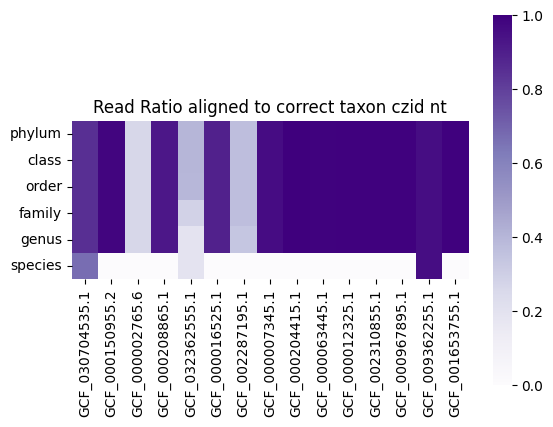

In [48]:
nt_aligned_percentage = pd.DataFrame()
for t in rank_order[1:]:
    df = all_df_nt.groupby(t)[all_nt_col].sum()
    df = df.replace(0,np.nan)
    df.columns = df.columns.str.replace('_nt_rpm','' , regex=True)
    ref_t_dict = spc_info.set_index('refseq')[t].to_dict()
    for r in ref_order:
        ref = ref_t_dict[r]
        try:
            a = df.loc[ref,r]
        except KeyError:
            a = 0
        #print(a)
        nt_aligned_percentage.loc[t,r]=a
sns.heatmap(nt_aligned_percentage, square=True,cmap='Purples',vmin=0, vmax=1)
plt.title("Read Ratio aligned to correct taxon czid nt")
plt.savefig(out_dir+'Read_Ratio_aligned_to_correct_taxon_czid_nt.pdf')

plt.show()
        
nt_aligned_percentage.to_csv(out_dir+'Read_Ratio_aligned_to_correct_taxon_czid_nt.csv')

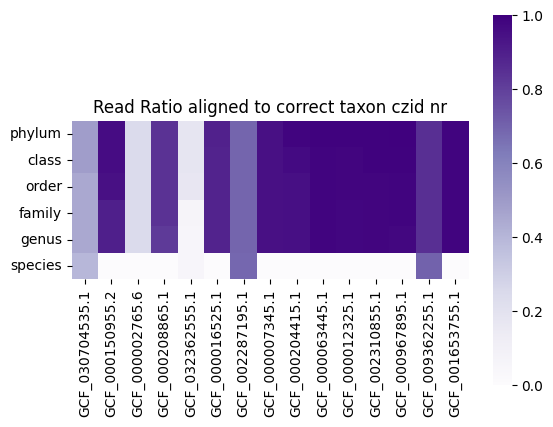

In [49]:
nr_aligned_percentage = pd.DataFrame()
for t in rank_order[1:]:
    df = all_df_nr.groupby(t)[all_nr_col].sum()
    df = df.replace(0,np.nan)
    df.columns = df.columns.str.replace('_nr_rpm','' , regex=True)
    ref_t_dict = spc_info.set_index('refseq')[t].to_dict()
    for r in ref_order:
        ref = ref_t_dict[r]
        try:
            a = df.loc[ref,r]
        except KeyError:
            a = 0
        #print(a)
        nr_aligned_percentage.loc[t,r]=a
sns.heatmap(nr_aligned_percentage, square=True,cmap='Purples',vmin=0, vmax=1,)
plt.title("Read Ratio aligned to correct taxon czid nr")
plt.savefig(out_dir+'Read_Ratio_aligned_to_correct_taxon_czid_nr.pdf')

plt.show()
nr_aligned_percentage.to_csv(out_dir+'Read_Ratio_aligned_to_correct_taxon_czid_nr.csv')

In [50]:
spc_info.set_index('refseq')[t].to_dict()

{'GCF_000002765.6': 'Plasmodium falciparum 3D7',
 'GCF_000007345.1': 'Methanosarcina acetivorans C2A',
 'GCF_000012325.1': 'Colwellia psychrerythraea 34H',
 'GCF_000016525.1': 'Methanobrevibacter smithii ATCC 35061',
 'GCF_000063445.1': 'Methanocella arvoryzae MRE50',
 'GCF_000150955.2': 'Phaeodactylum tricornutum CCAP 1055/1',
 'GCF_000204415.1': 'Methanothrix soehngenii GP6',
 'GCF_000208865.1': 'Neospora caninum Liverpool',
 'GCF_000967895.1': 'Oleispira antarctica RB-8',
 'GCF_001653755.1': 'Dokdonia donghaensis DSW-1',
 'GCF_002287195.1': 'Methanosphaera cuniculi',
 'GCF_002310855.1': 'Pseudoalteromonas agarivorans DSM 14585',
 'GCF_009362255.1': 'Tenacibaculum mesophilum',
 'GCF_030704535.1': 'Vitis vinifera',
 'GCF_032362555.1': 'Amyelois transitella'}

# plot combined figures


# make trees for all the simulation data
step: 
1. get all the ncbi ids from different method
2. generate tree
3. make barplot for each specie's 